In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
from bokeh.plotting import figure, show, output_notebook
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
from sodapy import Socrata
import geopandas as gpd
import os

output_notebook()

Loading BokehJS ...

# The Data Incubator - Proposal
# Chicago Rideshare

## Description / Problems Statement

### Get data

In [2]:
filename = 'Transportation_Network_Providers_Trips.csv'
raw_df = pd.read_csv(filename,
#                      nrows=10000,
                     usecols=['Trip ID',
                              'Fare','Tip',
                              'Trip Total',
                              'Shared Trip Authorized',
                              'Trips Pooled', 
                              'Trip Start Timestamp',
                              'Pickup Community Area',
                              'Dropoff Community Area'])

## Question: Is it worth taking Uber Pool? (if you'd rather ride alone) 

In [3]:
share_df = raw_df.loc[raw_df['Shared Trip Authorized'] == True].copy()
solo_df = raw_df.loc[raw_df['Shared Trip Authorized'] == False].copy()
solo_df = solo_df[solo_df['Trips Pooled'] == 1]

In [4]:
avg_solo_fare = np.around(np.mean(solo_df['Fare']), decimals=2)
avg_solo_tip = np.around(np.mean(solo_df['Tip']), decimals=2)
avg_solo_triptotal = np.around(np.mean(solo_df['Trip Total']), decimals=2)

In [5]:
grouped_share_df = share_df.groupby('Trips Pooled').agg({'Fare': np.mean,
                                                         'Tip': np.mean,
                                                         'Trip Total': np.mean,
                                                         'Shared Trip Authorized': 'count'})
grouped_share_df.reset_index(inplace=True)
grouped_share_df['Trip Count Corrected']= grouped_share_df['Shared Trip Authorized']/grouped_share_df['Trips Pooled']

In [6]:
avg_shared_fare = np.around(grouped_share_df.loc[grouped_share_df['Trips Pooled']==1, 'Fare'][0], decimals=2)
avg_shared_tip = np.around(grouped_share_df.loc[grouped_share_df['Trips Pooled']==1, 'Tip'][0], decimals=2)
avg_shared_triptotal = np.around(grouped_share_df.loc[grouped_share_df['Trips Pooled']==1, 'Trip Total'][0], decimals=2)

print('The average fare for a single rider on a solo trip is $'+str(avg_solo_fare))
print('The average tip for a single rider on a solo trip is $'+str(avg_solo_tip))
print('The average trip total for a single rider on a solo trip is $'+str(avg_solo_triptotal))
print()
print('The average fare for any rider on a shared trip is $'+str(avg_shared_fare))
print('The average tip for any rider on a shared trip is $'+str(avg_shared_tip))
print('The average trip total for any rider on a shared trip is $'+str(avg_shared_triptotal))

The average fare for a single rider on a solo trip is $11.86
The average tip for a single rider on a solo trip is $0.65
The average trip total for a single rider on a solo trip is $15.72

The average fare for any rider on a shared trip is $8.72
The average tip for any rider on a shared trip is $0.21
The average trip total for any rider on a shared trip is $10.34


### What's the percent of Uber Pool rides with only 1 rider?

In [7]:
total_trips = sum(grouped_share_df['Trip Count Corrected'])
grouped_share_df['percent_of_total_trips'] = 100*grouped_share_df['Trip Count Corrected']/total_trips

print(grouped_share_df.percent_of_total_trips[0])

51.12078805011262


#### FUN FACT: You have a 50/50 chance of riding alone if you take an uber pool

### What's the average number of riders per shared trip?

In [8]:
avg_riders = sum(grouped_share_df['Trips Pooled']*grouped_share_df['percent_of_total_trips']/100)
print(avg_riders)

1.7411924418939937


In [9]:
del solo_df
del share_df
del grouped_share_df

## Question: Can drivers optimize fare by pickup spot?

In [10]:
nn_dict = {1: [2,77], 2 : [1,4,13,77], 3 : [4,5,6,77], 4 : [2,3,5,6,13,14,16,77], 5 : [3,4,6,7,14,16,21,22],
           6 : [3,4,5,7], 7 : [5,6,8,22,24], 8 : [7,24,28,32], 9 : [10], 10: [9,11,12,15,76], 11: [10,12,15], 
           12: [10,11,13,14,15,16], 13: [2,4,12,14], 14: [4,5,12,13,15,16], 15: [11,12,14,16,17,19,20],
           16: [4,5,12,14,15,19,20,21], 17: [15,18,19,76], 18: [17,19,25], 19: [15,16,17,18,20,23,25],
           20: [15,16,19,21,22,23,25], 21: [5,16,20,22], 22: [5,7,20,21,23,24], 23: [19,20,22,24,25,26,27,28],
           24: [7,8,22,23,27,28], 25: [18,19,20,23,26,29], 26: [23,25,27,29], 27: [23,24,26,28,29],
           28: [8,23,24,27,29,31,32,33,34], 29: [25,26,27,28,30,31], 30: [29,31,56,57,58,59], 
           31: [28,29,30,33,34,58,59,60], 32: [8,28,33], 33: [28,31,32,34,35], 34: [28,31,33,35,37,38,60,61],
           35: [33,34,36,37,38], 36: [35,38,39], 37: [34,35,38,40,60,61,68], 38: [34,35,36,37,39,40,41], 
           39: [36,38,40,41], 40: [37,38,39,41,42,68,69], 41: [38,39,40,42], 42: [40,41,43,69], 43: [42,45,46,69],
           44: [45,47,48,49,50,69,71], 45: [43,44,46,47,48,69], 46: [43,45,48,51,52], 47: [44,45,48,49,50,51],
           48: [44,45,46,47,50,51], 49: [44,47,50,53,54,71,73,75], 50: [44,47,48,49,51,53,54],
           51: [46,47,48,50,52,54,55], 52: [46,51,55], 53: [49,50,54,75], 54: [49,50,51,53,55], 55: [51,52,54], 
           56: [57,62,64,65], 57: [30,56,58,62,63], 58: [30,31,57,59,61,62,63], 59: [30,31,58,60,61],
           60: [31,34,37,59,61], 61: [34,37,58,59,60,63,67,68], 62: [56,57,58,63,64,65,66], 63: [57,58,61,62,65,66,67],
           64: [56,62,65], 65: [56,62,63,64,66], 66: [62,63,65,67,70,71], 67: [61,63,66,68,70,71], 
           68: [37,40,61,67,69,71], 69: [40,42,43,44,45,68,71], 70: [65,66,67,71,72], 71: [44,49,66,67,68,69,70,72,73],
           72: [70,71,73,74,75], 73: [44,49,71,73,75], 74: [72,75], 75: [49,53,72,73,74], 76: [10,17], 77: [1,2,3,4]
          } 

In [11]:
time_df = raw_df.copy()
time_df['hour'] = time_df['Trip Start Timestamp'].apply(lambda x : datetime.strptime(x,"%m/%d/%Y %I:%M:%S %p").hour)

In [12]:
earnings_df = time_df[['hour','Pickup Community Area','Fare', 'Tip', 'Trip Total']]\
.groupby(['Pickup Community Area','hour']).mean()

earnings_df.reset_index(inplace=True)
earnings_df.head()

,Pickup Community Area,hour,Fare,Tip,Trip Total
0,1.0,0,8.515030,0.416097,11.182216
1,1.0,1,8.426947,0.434733,11.110584
2,1.0,2,8.458933,0.445646,11.206309
3,1.0,3,9.884697,0.513675,13.038200
4,1.0,4,11.601322,0.571005,15.145201


In [13]:
del time_df

#### Function to rate starting regions

In [14]:
def rate_fare(start_region, hour):
    try:
        ratedfare = earnings_df[(earnings_df['Pickup Community Area']==start_region)\
                          & (earnings_df['hour']==hour)]['Fare'].values[0]
    except:
        ratedfare = 0
    return ratedfare

#### Function to return nearest neighbor fares (+ "best" neighbor)

In [15]:
def neighbor_fares(region, hour):
    start_pts = nn_dict[region].copy()
    start_pts.append(region)
    current_fare = 0
    best_start_point = start_pts[0]
    fares = {}
    for start_pt in start_pts:
        ratedfare = rate_fare(start_region=start_pt,
                               hour=hour)
        fares[start_pt] = ratedfare

        if ratedfare >= current_fare:
            current_fare = ratedfare
            best_start_point = start_pt
    return best_start_point, fares

#### Function to calculate improvement over current region

In [16]:
def get_improvement(region, hour):
    _, fares = neighbor_fares(region, hour)
    current_fare = fares[region]
    imp = {}
    for start_pt in fares.keys():
        if current_fare != 0:
            imp[start_pt] = 100*(fares[start_pt] - current_fare)/current_fare
        else:
            imp[start_pt] = 0
    return imp

In [17]:
def plot_optimal_neighbor(region, hour):
    shapefile = 'Boundaries - Community Areas (current)/geo_export_8e0443c6-f7e4-49a6-b221-6511227b65da.shp'
    #Read shapefile using Geopandas
    gdf = gpd.read_file(shapefile) [['community', 'area_numbe', 'geometry']]
    
    imp = get_improvement(region, hour)
    
    imp_df = pd.DataFrame(columns = ['region', 'improvement'])
    imp_df['region'] = [str(x) for x in imp.keys()]
    imp_df['improvement'] = imp.values()
    
    merged = pd.merge(gdf, imp_df, left_on='area_numbe', right_on='region')
    
    # set a variable that will call whatever column we want to visualise on the map
    variable = 'improvement'
    # set the range for the choropleth
    vmin, vmax = 0, (merged['improvement'].max())
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(10, 6))

    merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

    # remove the axis
    ax.axis('off')

    # add a title
    ax.set_title('Improved Fares in Nearby Regions', fontdict={'fontsize': '25', 'fontweight' : '3'})
    # create an annotation for the data source
    ax.annotate('Source: Chicago DATA SOURCE',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)
    
    

#### Map shows fare improvement (in %) in nearby regions

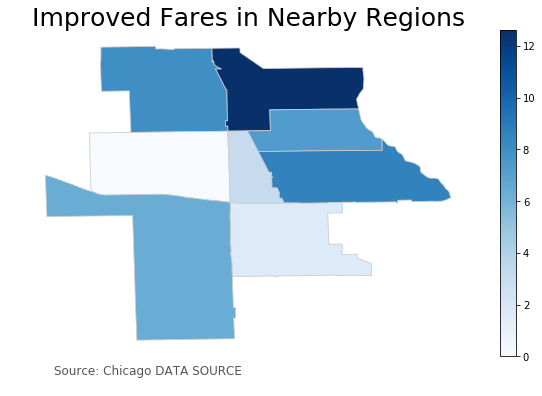

In [25]:
plot_optimal_neighbor(20, 8)

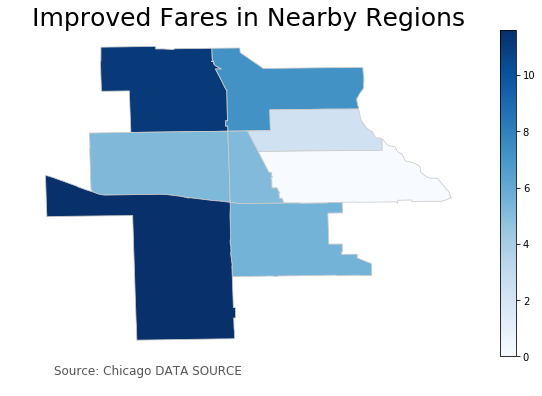

In [24]:
plot_optimal_neighbor(20, 20)

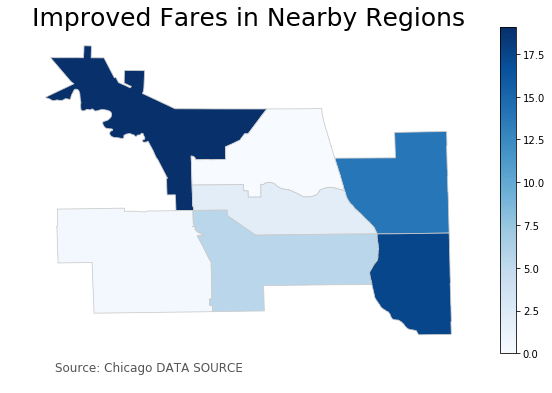

In [26]:
plot_optimal_neighbor(14, 8)

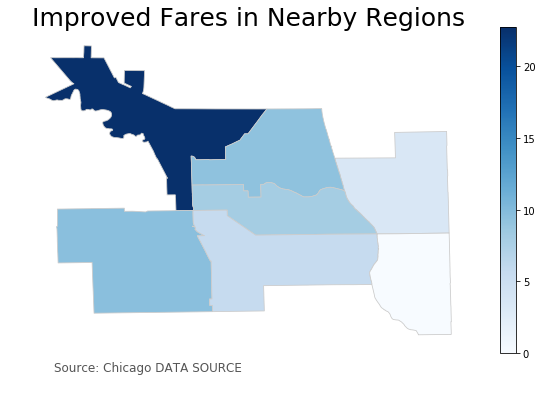

In [28]:
plot_optimal_neighbor(14, 22)

#### What is the average improvement you can achieve using this method?

In [31]:
hour = 20
imps = []
for region in nn_dict.keys():
    best_neighbor, fares = neighbor_fares(region, hour)
    best_rate = fares[best_neighbor]
    current_rate = fares[region]
    imp = 100*(best_rate - current_rate)/current_rate
    imps.append(imp)

np.mean(imps)

21.69578789983986